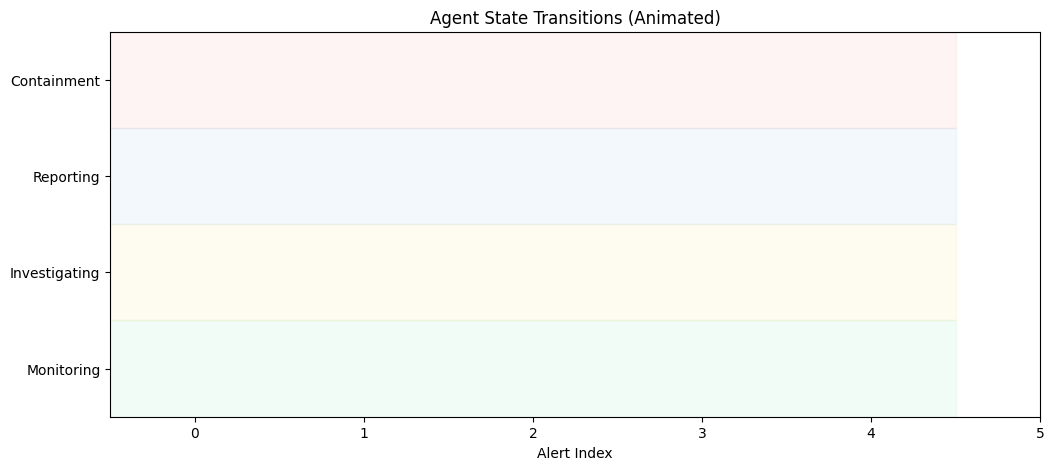

In [2]:
# Animated FSM timeline inside Jupyter (matplotlib.animation)
import json                               # ✅ Add this line
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from matplotlib.patches import Rectangle
from IPython.display import HTML

# Use current `trace` (list of dict entries produced earlier)
# Ensure trace exists
if 'trace' not in globals():
    with open("artifacts/agent_trace.json") as f:
        trace = json.load(f)

state_order = {"Monitoring": 0, "Investigating": 1, "Reporting": 2, "Containment": 3}
state_labels = list(state_order.keys())
state_colors = {"Monitoring":"#2ecc71","Investigating":"#f1c40f","Reporting":"#3498db","Containment":"#e74c3c"}

times = np.arange(len(trace))
states = [state_order[e["state"]] for e in trace]
packets = [e.get("packet_idx", None) for e in trace]
probs = [e.get("prob", 0.0) for e in trace]

fig, ax = plt.subplots(figsize=(12,5))
ax.set_xlim(-0.5, max(5, len(trace)-1 + 0.5))  # show at least a few slots
ax.set_ylim(-0.5, len(state_order)-0.5)

# background shading
for state, y in state_order.items():
    ax.add_patch(Rectangle((-0.5, y - 0.5), len(trace) + 2, 1, color=state_colors[state], alpha=0.06, zorder=0))

ax.set_yticks(list(state_order.values()))
ax.set_yticklabels(state_labels)
ax.set_xlabel("Alert Index")
ax.set_title("Agent State Transitions (Animated)")

scat = ax.scatter([], [], s=140, edgecolor='black', zorder=5)
line, = ax.plot([], [], linewidth=2, alpha=0.6)

annot = ax.text(0,0,"", fontsize=9, va="bottom", ha="center",
                bbox=dict(facecolor="white", alpha=0.8, boxstyle="round"))

def init():
    scat.set_offsets(np.empty((0,2)))
    line.set_data([], [])
    annot.set_text("")
    return scat, line, annot

def update(frame):
    # frame: 0..len(trace)-1
    x = list(range(frame+1))
    y = [states[i] for i in x]
    colors = [state_colors[list(state_order.keys())[s]] for s in y]
    offsets = np.column_stack([x, y])
    scat.set_offsets(offsets)
    scat.set_color(colors)
    line.set_data(x, y)
    # annotate last point
    last = frame
    pkt = packets[last]
    prob = probs[last]
    annot.set_position((last, states[last]+0.12))
    annot.set_text(f"{pkt}\n({prob:.2f})")
    return scat, line, annot

ani = animation.FuncAnimation(fig, update, frames=len(trace), init_func=init,
                              interval=700, blit=False, repeat=False)

# Display inline animation
HTML(ani.to_jshtml())


2025-11-09 00:43:18.324 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-09 00:43:18.326 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-09 00:43:18.583 
  command:

    streamlit run d:\project\Network Traffic Analysis and Packet Inspection using ML and Agentic AI\.venv\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-11-09 00:43:18.584 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-09 00:43:18.585 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-09 00:43:18.589 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-09 00:43:18.591 Thread 'MainThread': 

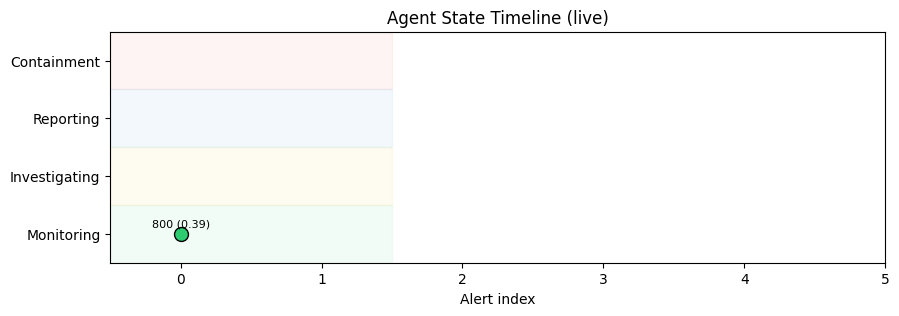

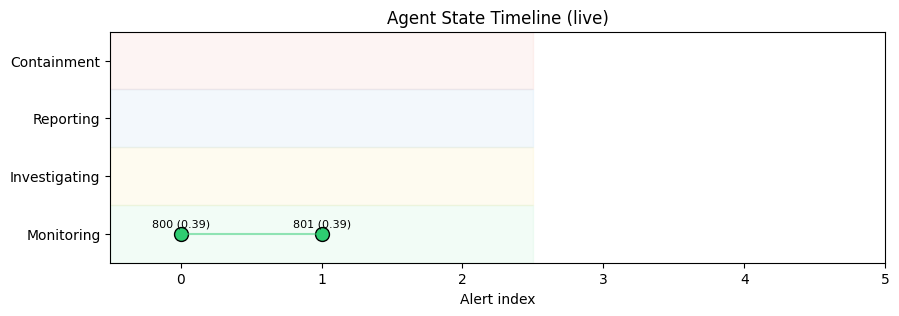

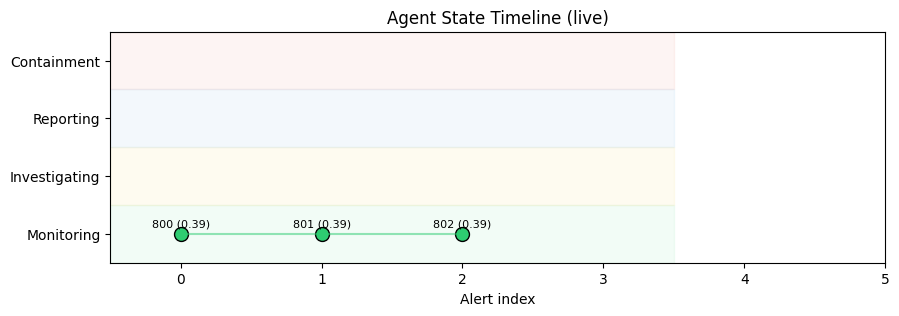

In [3]:
# snippet for streamlit_app.py — timeline updater (insert into your Streamlit app)
import streamlit as st
import matplotlib.pyplot as plt
import numpy as np
import json
from matplotlib.patches import Rectangle
import time

st.set_page_config(layout="wide")
timeline_placeholder = st.empty()

# load alerts
with open("artifacts/eval/example_alerts.json") as f:
    alerts = json.load(f)

state_order = {"Monitoring": 0, "Investigating": 1, "Reporting": 2, "Containment": 3}
state_colors = {"Monitoring":"#2ecc71","Investigating":"#f1c40f","Reporting":"#3498db","Containment":"#e74c3c"}

# simulate streaming ingestion
stream_speed = st.sidebar.slider("Stream speed (s per alert)", 0.3, 2.0, 0.6)

streamed = []
for i, a in enumerate(alerts):
    # append to streamed
    streamed.append(a)
    # create plot
    times = np.arange(len(streamed))
    states = [state_order[s.get("state", "Monitoring")] if isinstance(s, dict) and "state" in s else 0 for s in streamed]
    packets = [s.get("packet_idx", None) for s in streamed]
    probs = [s.get("prob", s.get("packet_base_prob",0.0)) for s in streamed]

    fig, ax = plt.subplots(figsize=(10,3))
    for st_name, y in state_order.items():
        ax.add_patch(Rectangle((-0.5, y - 0.5), len(streamed)+1, 1, color=state_colors[st_name], alpha=0.06))
    # connect points
    for j in range(len(streamed)):
        color = state_colors[list(state_order.keys())[states[j]]]
        ax.scatter(j, states[j], color=color, edgecolor='black', s=100)
        if j>0:
            ax.plot([j-1, j], [states[j-1], states[j]], color=color, alpha=0.5)
        ax.text(j, states[j]+0.12, f"{packets[j]} ({probs[j]:.2f})", ha='center', fontsize=8)

    ax.set_yticks(list(state_order.values()))
    ax.set_yticklabels(list(state_order.keys()))
    ax.set_xlim(-0.5, max(5, len(streamed)-1 + 0.5))
    ax.set_ylim(-0.5, 3.5)
    ax.set_xlabel("Alert index")
    ax.set_title("Agent State Timeline (live)")
    timeline_placeholder.pyplot(fig)
    time.sleep(stream_speed)
